<a href="https://colab.research.google.com/github/lacykaltgr/continual-learning-ait/blob/main/notebooks/generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''Download the files '''
'''Only for colab'''

!wget https://github.com/lacykaltgr/continual-learning-ait/archive/refs/heads/experiment.zip
!unzip experiment.zip
!find continual-learning-ait-experiment -type f ! -name "main.ipynb" -exec cp {} . \;

!rm -r models
!mkdir models

--2023-05-14 11:58:58--  https://github.com/lacykaltgr/continual-learning-ait/archive/refs/heads/experiment.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/lacykaltgr/continual-learning-ait/zip/refs/heads/experiment [following]
--2023-05-14 11:58:58--  https://codeload.github.com/lacykaltgr/continual-learning-ait/zip/refs/heads/experiment
Resolving codeload.github.com (codeload.github.com)... 20.27.177.114
Connecting to codeload.github.com (codeload.github.com)|20.27.177.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘experiment.zip’

experiment.zip          [  <=>               ]   1.58M  4.51MB/s    in 0.4s    

2023-05-14 11:58:59 (4.51 MB/s) - ‘experiment.zip’ saved [1659988]

Archive:  experiment.zip
14284730675b047d64453bf87dfeefdb10cc020d
   cre

In [2]:
from keras.models import load_model
import tensorflow as tf
import keras
import numpy as np
from keras.layers import Conv2D, Conv2DTranspose
import math
from constants import _ALPHAS_CUMPROD

In [3]:
def load_cifar_10():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
    n_classes = 10
    X_train = (X_train / 127.5) -1
    X_test = (X_test / 127.5) -1
    y_train = tf.keras.utils.to_categorical(y_train, n_classes)
    y_test = tf.keras.utils.to_categorical(y_test, n_classes)
    return (X_train, y_train), (X_test, y_test)

In [78]:

encoder = load_model("encoder.h5")
classifier = load_model("classifier.h5")

encoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

input = keras.Input(shape=(32,32,3))
enc = encoder(input)
cls = classifier(enc)
encoder_classifier = keras.Model(inputs=[input], outputs=[cls])

encoder_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [5]:
def apply_seq(x: object, layers: object) -> object:
    for l in layers:
        x = l(x)
    return x

In [6]:
class ResBlock(keras.layers.Layer):
    def __init__(self, channels, out_channels):
        super().__init__()
        self.in_layers = [
            keras.layers.GroupNormalization(epsilon=1e-5),
            keras.activations.swish,
            Conv2D(out_channels, 3, strides=(1, 1), padding='same'),
        ]
        self.emb_layers = [
            keras.activations.swish,
            keras.layers.Dense(out_channels),
        ]
        self.out_layers = [
            keras.layers.GroupNormalization(epsilon=1e-5),
            keras.activations.swish,
            Conv2D(out_channels, 3, strides=(1, 1), padding='same'),
        ]
        self.skip_connection = Conv2D(out_channels, 3, strides=(1, 1), padding='same') if channels != out_channels else lambda x: x

    def call(self, inputs):
        x, emb = inputs
        h = apply_seq(x, self.in_layers)
        emb_out = apply_seq(emb, self.emb_layers)
        h = h + emb_out[:, None, None]
        h = apply_seq(h, self.out_layers)
        skip_x = self.skip_connection(x)
        ret = skip_x + h
        return ret

In [7]:
class UNetModel(keras.Model):
    def __init__(self):
        print("UNetModel init")
        super().__init__()
        self.img_height = 32
        self.img_width = 32
        self.ntype = tf.float32
        self.time_embed = [
            keras.layers.Dense(128),
            keras.activations.swish,
            keras.layers.Dense(128),
        ]
        self.input_blocks = [
            Conv2D( 32, 3, strides=(1, 1), padding='same'),

            ResBlock(32, 32),
            ResBlock(32, 32),
            Conv2D(64, 3, strides=(2, 2), padding='same'), #downsample

            ResBlock(32, 64), 
            ResBlock(64, 64), 
            Conv2D(128, 3, strides=(2, 2), padding='same'), #downsample

            ResBlock(64, 128),
            ResBlock(128, 128),
            Conv2D(128, 3, strides=(2, 2), padding='same'), #downsample

            ResBlock(128, 128),
            ResBlock(128, 128),
        ]
        self.middle_block = [
            ResBlock(256, 128),
            ResBlock(256, 128),
        ]
        self.output_blocks = [
            [ResBlock(256, 128)],
            [ResBlock(256, 128)],

            [
                ResBlock(256, 128),
                Conv2DTranspose(128, 2, strides=(2,2)),
                Conv2D(128, 3, strides=(1,1), padding='same')
            ],
            [ResBlock(256, 128)], 
            [ResBlock(256, 128)],

            [
                ResBlock(192, 128),
                Conv2DTranspose(128, 2, strides=(2,2)),
                Conv2D(64, 2, strides=(1,1), padding='same')
            ],
            [ResBlock(192, 64)], 
            [ResBlock(128, 64)], 

            [
                ResBlock(96, 64),
                Conv2DTranspose(64, 3, strides=(2,2)),
                Conv2D(64, 2, strides=(1,1), padding='valid')
            ],
            [ResBlock(96, 32)], 
            [ResBlock(64, 32)],

            [ResBlock(64, 32)],
        ]
        self.out = [
            keras.layers.GroupNormalization(epsilon=1e-5),
            keras.activations.swish,
            Conv2D(3, 3, strides=(1,1), padding='same'),
        ]

    def call(self, inputs):
        x, t_emb = inputs
        emb = apply_seq(t_emb, self.time_embed)

        def apply(x, layer):
            return layer([x, emb]) if isinstance(layer, ResBlock) else layer(x)

        saved_inputs = []
        for layer in self.input_blocks:
            x = apply(x, layer)
            saved_inputs.append(x)

        for layer in self.middle_block:
            x = apply(x, layer)

        for b in self.output_blocks:
            skip = saved_inputs.pop()
            x = tf.concat([x, skip], axis=-1)
            for layer in b:
                x = apply(x, layer)

        return apply_seq(x, self.out)

    def initialize(self, params, input_latent=None, batch_size=64):
        timesteps = np.arange(1, params['num_steps']+ 1)
        input_lat_noise_t = timesteps[int(len(timesteps)* params["input_latent_strength"])]
        latent, alphas, alphas_prev = self.get_starting_parameters(
            timesteps, batch_size, input_latent=input_latent, input_lat_noise_t=input_lat_noise_t
        )
        timesteps = timesteps[: int(len(timesteps)*params["input_latent_strength"])]
        return latent, alphas, alphas_prev, timesteps


    def get_x_prev(self, x, e_t, a_t, a_prev, temperature):
        sigma_t = 0
        sqrt_one_minus_at = math.sqrt(1 - a_t)
        pred_x0 = x - sqrt_one_minus_at * e_t / math.sqrt(a_t)

        # Direction pointing to x_t
        dir_xt = math.sqrt(1.0 - a_prev - sigma_t**2) * e_t
        #noise = sigma_t * tf.random.normal(x.shape, seed=seed) * temperature
        x_prev = math.sqrt(a_prev) * pred_x0 + dir_xt
        return x_prev


    def get_model_output(self, latent, timestep, batch_size):
        timesteps = tf.convert_to_tensor([timestep], dtype=tf.float32)
        t_emb = self.timestep_embedding(timesteps)
        t_emb = tf.repeat(t_emb, repeats=batch_size, axis=0)
        latent = self.call([latent, t_emb])
        return latent


    def timestep_embedding(self, timesteps, dim=320, max_period=10000):
        half = dim // 2
        freqs = np.exp(
            -math.log(max_period) * np.arange(0, half, dtype="float32") / half
        )
        args = np.array(timesteps) * freqs
        embedding = np.concatenate([np.cos(args), np.sin(args)])
        return tf.convert_to_tensor(embedding.reshape(1, -1), dtype=self.ntype)



    # for model with input latent

    def add_noise(self, x, t, noise=None):
        if len(x.shape) == 3:
            x = tf.expand_dims(x, axis=0)
        batch_size, w, h, c = x.shape[0], x.shape[1], x.shape[2], x.shape[3]
        if noise is None:
            noise = tf.random.normal((batch_size, w, h, c), dtype=tf.float32)
        sqrt_alpha_prod = tf.cast(_ALPHAS_CUMPROD[t] ** 0.5, tf.float32)
        sqrt_one_minus_alpha_prod = (1 - _ALPHAS_CUMPROD[t]) ** 0.5

        return sqrt_alpha_prod * x + sqrt_one_minus_alpha_prod * noise

    def get_starting_parameters(self, timesteps, batch_size,  input_latent=None, input_lat_noise_t=None):
        n_h = self.img_height
        n_w = self.img_width
        alphas = [_ALPHAS_CUMPROD[t] for t in timesteps]
        alphas_prev = [1.0] + alphas[:-1]
        if input_latent is None:
            latent = tf.random.normal((batch_size, n_h, n_w, 3))
        else:
            input_latent = tf.cast(input_latent, self.ntype)
            #latent = tf.repeat(input_latent , batch_size , axis=0)
            latent = self.add_noise(input_latent, input_lat_noise_t)
        return latent, alphas, alphas_prev


In [8]:
def get_one_hot_predictions(mem_pred):
    maximum = np.argmax(mem_pred, axis=1)
    num_classes = mem_pred.shape[1]
    mem_true = np.zeros_like(mem_pred)
    mem_true[np.arange(len(maximum)), maximum] = 1
    return mem_true

In [9]:
'''Generate samples and train the diffusion model at the same time'''

#plusz lehetne itt még kritérium hogy ne menjen olyan messze az alaptól --- similarity loss
#plusz még lehetne talán egy discriminator is, hogy valós reprezentációkat tanuljon meg


def generate(cls=classifier, enc=encoder,  input_latent=None, train=True, coeff=1.0):

    if len(input_latent.shape) == 3:
        input_latent = tf.expand_dims(input_latent, axis=0)
    batch_size = input_latent.shape[0] 
    batch_size = batch_size if batch_size is not None else 1
    latent, alphas, alphas_prev, timesteps = model.initialize(params, input_latent, batch_size)


    for index, timestep in reversed(list(enumerate(timesteps))):
        if train:
            with tf.GradientTape() as tape:
                e_t = model.get_model_output(
                    latent,
                    timestep,
                    batch_size,
                )
                a_t, a_prev = alphas[index], alphas_prev[index]
                latent = model.get_x_prev(latent, e_t,  a_t, a_prev, params["temperature"])
                encoded = enc(latent)
                pred = cls(encoded)
                pred_true = pred#get_one_hot_predictions(pred) #ezt nem fixen kell mecsinálni
                confidence_loss = coeff*tf.reduce_mean(tf.keras.losses.categorical_crossentropy(pred_true, pred))
                #print(confidence_loss)
                #similarity_loss = 0.1 * tf.reduce_mean(tf.square(latent - e_t))
                #print(similarity_loss)
                loss = confidence_loss #+ similarity_loss
            grads = tape.gradient(loss, model.trainable_variables)
            tf.keras.optimizers.legacy.Adam(learning_rate=params["gen_lr"]).apply_gradients(zip(grads, model.trainable_variables))
        else:
            e_t = model.get_model_output(
                latent,
                timestep,
                batch_size,
            )
            a_t, a_prev = alphas[index], alphas_prev[index]
            latent = model.get_x_prev(latent, e_t,  a_t, a_prev, params["temperature"])

    return latent

In [10]:
model = UNetModel()

UNetModel init


In [75]:
params = {
    "num_steps": 10,
    "input_latent_strength": 0.5,
    "temperature": 0.9,
    "batch_size": 256,
    "gen_lr": 2e-5,
    "n_epoch": 1,
}

In [12]:
(X_train, y_train), (X_test, y_test) = load_cifar_10()

170498071/170498071 [==============================] - 11s 0us/step


In [25]:
X_train.shape

(50000, 32, 32, 3)

In [71]:
y_truck = np.argmax(y_train, axis=1)
condition = np.logical_or(np.logical_or(y_truck == 1, y_truck == 2), y_truck == 3)
X_truck = X_train[condition]
X_truck.shape

(15000, 32, 32, 3)

In [72]:
for epoch in range(params["n_epoch"]):
    loss = []
    for i in range(0, X_truck.shape[0], params["batch_size"]):
        X_batch = X_truck[i:i+params["batch_size"]]
        mem_x = generate(input_latent=X_batch, train=True)
        mem_enc = encoder(mem_x)
        mem_pred = classifier(mem_enc)
        mem_pred_true = get_one_hot_predictions(mem_pred)
        mem_loss = tf.keras.losses.categorical_crossentropy(mem_pred_true, mem_pred)
        loss.append(np.mean(mem_loss))
        print(np.mean(mem_loss))
    print("Loss on generate: ",  np.mean(loss))

0.4242369
0.33114964
0.30617577
0.20232084
0.1963116
0.1683407
0.18010171
0.11218709
0.09894572
0.051574066
0.029566148
0.03474347
0.027091656
0.02957435
0.009589035
0.0134067945
0.0051059574
0.008027151


KeyboardInterrupt: ignored

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def disp(image):
    image = (image + 1)* 127.5

    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    plt.show()

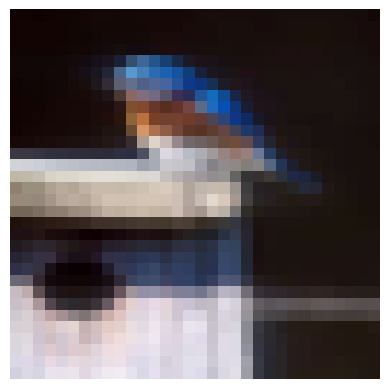

7


In [55]:
disp(X_train[13])
encoded = encoder(tf.expand_dims(X_train[12], axis=0))
classified = classifier(encoded)
print(np.argmax(classified))

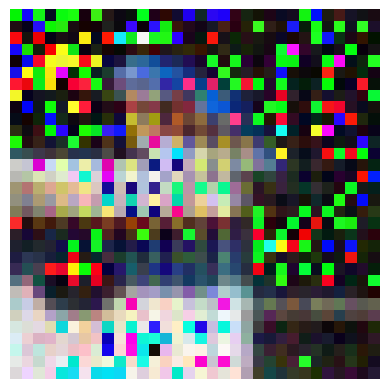

In [63]:
image = generate(input_latent=X_train[13], train=False)
disp(image[0].numpy())

In [65]:
encoded = encoder(image)
classified = classifier(encoded)
print(np.argmax(classified))
np.max(classified)

9


0.9624662

In [20]:
print(y_train[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


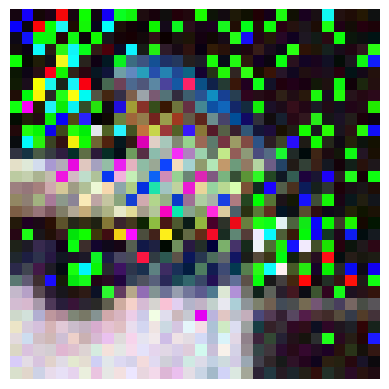

In [76]:
image = generate(input_latent=X_train[13], train=False)
disp(image[0].numpy())

In [77]:
encoded = encoder(image)
classified = classifier(encoded)
print(np.argmax(classified))
np.max(classified)

6


0.99973315